# 1. Data Preparation
We load the training/testing data from the Hugging Face dataset `chen1028/Cl-Containing-Compound`\. The dataset contains engineered MS1 isotopic features and a binary label `has_cl` indicating chlorine presence.

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from datasets import load_dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

## 1. Loading and Exploring Data

We will load the chlorine presence dataset from Hugging Face (`chen1028/Cl-Containing-Compound`) and explore its structure.

In [2]:
# Load train/test from Hugging Face (CSV files hosted in the dataset repo)
ds = load_dataset(
  "csv",
  data_files={
    "train": "hf://datasets/chen1028/Cl-Containing-Compound/train.csv",
    "test":  "hf://datasets/chen1028/Cl-Containing-Compound/test.csv",
  }
)

# Convert to pandas for exploration
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

# --- Create binary label from 'Cl' if present (0 -> 0, non-zero -> 1) ---
if "Cl" in train_df.columns:
    def _to_binary_cl(series):
        s = pd.to_numeric(series, errors="coerce").fillna(0)
        return (s != 0).astype(int)
    train_df["has_cl"] = _to_binary_cl(train_df["Cl"])
    if "Cl" in test_df.columns:
        test_df["has_cl"] = _to_binary_cl(test_df["Cl"])  # create label for test as well

# --- Detect / normalize label column if not already created ---
if "has_cl" not in train_df.columns:
    # Heuristic: look for a column with only {0,1} (or {1,0}) values, or named similarly
    candidate_cols = []
    for c in train_df.columns:
        lower = c.lower().strip()
        vals = set(train_df[c].dropna().unique().tolist())
        if lower in {"has_cl", "hascl", "label", "target", "class", "y"}:
            candidate_cols.append(c)
        elif len(vals) <= 2 and vals.issubset({0, 1, "0", "1"}):
            candidate_cols.append(c)
    # Deduplicate preserving order
    seen = set(); filtered = []
    for c in candidate_cols:
        if c not in seen:
            filtered.append(c); seen.add(c)
    if len(filtered) == 0:
        raise KeyError("Could not find label column. Available columns: " + ", ".join(train_df.columns))
    # Pick first candidate
    label_col = filtered[0]
    if label_col != "has_cl":
        print(f"Renaming detected label column '{label_col}' -> 'has_cl'")
        train_df.rename(columns={label_col: "has_cl"}, inplace=True)
        if label_col in test_df.columns:
            test_df.rename(columns={label_col: "has_cl"}, inplace=True)

# Ensure label numeric (0/1)
train_df["has_cl"] = train_df["has_cl"].astype(str).str.strip().replace({"0":0, "1":1}).astype(int)
if "has_cl" in test_df.columns:
    test_df["has_cl"] = test_df["has_cl"].astype(str).str.strip().replace({"0":0, "1":1}).astype(int)

print("Train shape:", train_df.shape, " Test shape:", test_df.shape)
print("Columns:", list(train_df.columns))
print("Label distribution (train):\n", train_df["has_cl"].value_counts())

print("Label distribution (test):\n", test_df["has_cl"].value_counts())
print("Columns:", list(test_df.columns))
print("Label distribution (test):\n", test_df["has_cl"].value_counts())

Train shape: (618272, 31)  Test shape: (154568, 31)
Columns: ['MF', 'Cl', 'mode', 'mw', 'mz0', 'mz1', 'mz2', 'theo_int1', 'theo_int2', 'theo_int3', 'int0', 'int1', 'int2', 'int2_o_int0', 'int1_o_int0', 'RI2_RI1', 'mz_2_0', 'mz_1_0', 'over_c', 'mz3', 'mz4', 'theo_int4', 'theo_int5', 'int3', 'int4', 'int3_o_int0', 'int4_o_int0', 'mz_3_0', 'mz_4_0', 'RI4_RI3', 'has_cl']
Label distribution (train):
 has_cl
1    309547
0    308725
Name: count, dtype: int64
Label distribution (test):
 has_cl
0    77695
1    76873
Name: count, dtype: int64
Columns: ['MF', 'Cl', 'mode', 'mw', 'mz0', 'mz1', 'mz2', 'theo_int1', 'theo_int2', 'theo_int3', 'int0', 'int1', 'int2', 'int2_o_int0', 'int1_o_int0', 'RI2_RI1', 'mz_2_0', 'mz_1_0', 'over_c', 'mz3', 'mz4', 'theo_int4', 'theo_int5', 'int3', 'int4', 'int3_o_int0', 'int4_o_int0', 'mz_3_0', 'mz_4_0', 'RI4_RI3', 'has_cl']
Label distribution (test):
 has_cl
0    77695
1    76873
Name: count, dtype: int64


/tmp/ipykernel_1191418/1736078034.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["has_cl"] = train_df["has_cl"].astype(str).str.strip().replace({"0":0, "1":1}).astype(int)
/tmp/ipykernel_1191418/1736078034.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df["has_cl"] = test_df["has_cl"].astype(str).str.strip().replace({"0":0, "1":1}).astype(int)


## 2. Data Splitting

Proper data splitting is crucial for unbiased model evaluation. We'll use the standard 80/10/10 split for training, validation, and testing sets respectively. Each set serves a specific purpose:

- **Training set (80%)**: Used to train the model
- **Validation set (10%)**: Used for hyperparameter tuning and model selection
- **Test set (10%)**: Used for final, unbiased evaluation of the best model

In [3]:
# Separate features and target from HF data
feature_cols = [c for c in train_df.columns if c not in ("has_cl", "Cl", "MF", "mode")]  # exclude label, source, and non-numeric cols
X_full = train_df[feature_cols]
y_full = train_df["has_cl"].astype(int)

# Create a validation split from the provided train
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.1, random_state=42, stratify=y_full
)

# Keep test from HF as given
X_test = test_df[feature_cols]
y_test = test_df["has_cl"].astype(int)

print("Splits:")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

Splits:
X_train: (556444, 27) X_val: (61828, 27) X_test: (154568, 27)


## 3. Data Cleaning: Handling Missing Values

Missing values are common in metabolomics data and can significantly impact model performance. We'll explore different imputation strategies:

1. **Remove features with high missing rates** (>50%)
2. **Mean/Median imputation** for numerical features
3. **Analysis of missing value patterns**

In [4]:
# Analyze missing value patterns on HF data
missing_percentages = (X_train.isnull().sum() / len(X_train)) * 100

print("Missing value analysis:")
print(f"Features with >50% missing values: {(missing_percentages > 50).sum()}")
print(f"Features with >20% missing values: {(missing_percentages > 20).sum()}")
print(f"Features with any missing values: {(missing_percentages > 0).sum()}")

Missing value analysis:
Features with >50% missing values: 0
Features with >20% missing values: 0
Features with any missing values: 4


In [5]:
# Step 1: Remove features with >50% missing values
high_missing_features = missing_percentages[missing_percentages > 50].index
print(f"Removing {len(high_missing_features)} features with >50% missing values")

X_train_clean = X_train.drop(columns=high_missing_features)
X_val_clean = X_val.drop(columns=high_missing_features)
X_test_clean = X_test.drop(columns=high_missing_features)

print(f"Remaining features: {X_train_clean.shape[1]}")

Removing 0 features with >50% missing values
Remaining features: 27


In [6]:
# Step 2: Impute remaining missing values using median imputation
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_clean),
    columns=X_train_clean.columns,
    index=X_train_clean.index
)
X_val_imputed = pd.DataFrame(
    imputer.transform(X_val_clean),
    columns=X_val_clean.columns,
    index=X_val_clean.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_clean),
    columns=X_test_clean.columns,
    index=X_test_clean.index
)

print("Missing values after imputation:")
print(f"Training set: {X_train_imputed.isnull().sum().sum()}")
print(f"Validation set: {X_val_imputed.isnull().sum().sum()}")
print(f"Test set: {X_test_imputed.isnull().sum().sum()}")

Missing values after imputation:
Training set: 0
Validation set: 0
Test set: 0


## 4. Feature Engineering and Scaling

Feature scaling is crucial for many machine learning algorithms, especially those that use distance measures. We'll demonstrate two common scaling techniques:

1. **Standardization (Z-score normalization)**: Centers data around mean=0, std=1
2. **Min-Max Scaling**: Scales features to a fixed range [0,1]

In [7]:
# Standardization (Z-score scaling)
from sklearn.preprocessing import StandardScaler
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train_imputed)
X_test_standard = scaler_standard.transform(X_test_imputed)
print('Standardized training data shape:', X_train_standard.shape)

# Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train_imputed)
X_test_minmax = scaler_minmax.transform(X_test_imputed)
print('Min-max scaled training data shape:', X_train_minmax.shape)

Standardized training data shape: (556444, 27)
Min-max scaled training data shape: (556444, 27)


Data shape for visualization: (556444, 27)
Target shape: (556444,)
Contains NaN: False


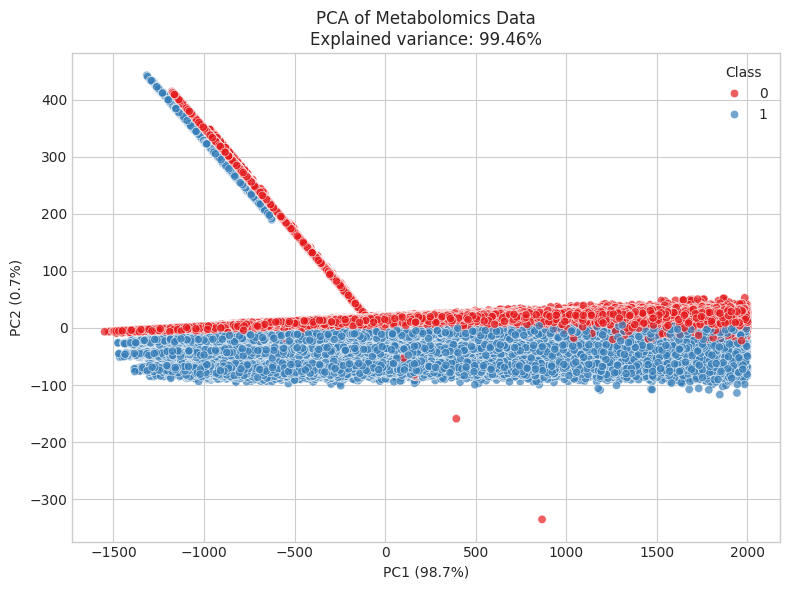

Running t-SNE... this may take a moment


/home/chen/miniconda3/envs/gnps/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


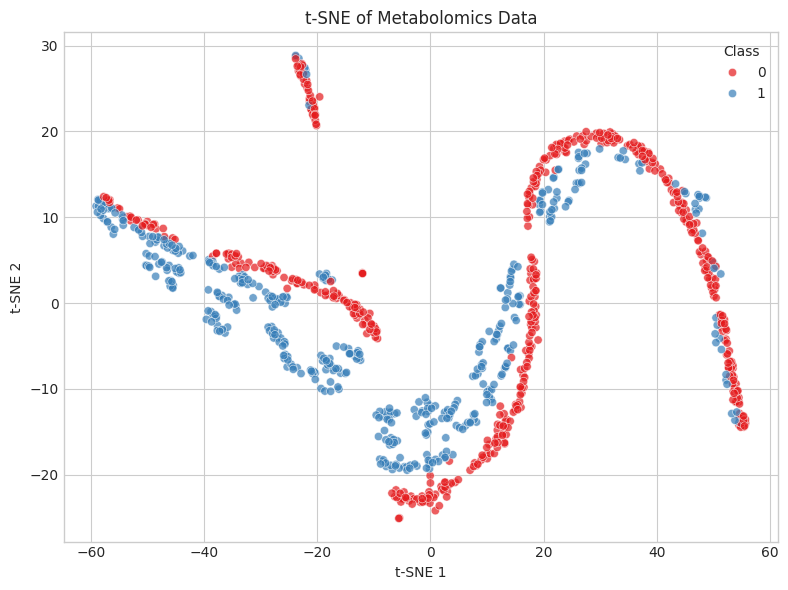

Dimensionality reduction completed successfully!


In [8]:
# PCA and t-SNE visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use the imputed and scaled data for visualization (no NaN values)
if 'X_train_imputed' in locals() and X_train_imputed is not None:
    X_vis = X_train_imputed.values if hasattr(X_train_imputed, 'values') else X_train_imputed
elif 'X_train_clean' in locals() and X_train_clean is not None:
    X_vis = X_train_clean.values if hasattr(X_train_clean, 'values') else X_train_clean
else:
    # Fallback: create simple clean data
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_vis = imputer.fit_transform(X_train)

y_vis = y_train if 'y_train' in locals() else y

# Ensure X_vis is 2D numpy array and has no NaN values
if hasattr(X_vis, 'values'):
    X_vis = X_vis.values
if len(X_vis.shape) == 1:
    X_vis = X_vis.reshape(-1, 1)

# Double-check for NaN values and handle them
if np.isnan(X_vis).any():
    print("Found NaN values, applying mean imputation...")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_vis = imputer.fit_transform(X_vis)

print(f"Data shape for visualization: {X_vis.shape}")
print(f"Target shape: {y_vis.shape}")
print(f"Contains NaN: {np.isnan(X_vis).any()}")

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_vis, palette='Set1', alpha=0.7)
plt.title(f'PCA of Metabolomics Data\nExplained variance: {pca.explained_variance_ratio_.sum():.2%}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

# t-SNE (can be slow on large datasets)
print("Running t-SNE... this may take a moment")
# Limit data size for t-SNE if too large
if len(X_vis) > 1000:
    indices = np.random.choice(len(X_vis), 1000, replace=False)
    X_tsne_input = X_vis[indices]
    y_tsne_input = y_vis.iloc[indices] if hasattr(y_vis, 'iloc') else y_vis[indices]
else:
    X_tsne_input = X_vis
    y_tsne_input = y_vis

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_tsne_input)//4), n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_input)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_tsne_input, palette='Set1', alpha=0.7)
plt.title('t-SNE of Metabolomics Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

print("Dimensionality reduction completed successfully!")

### Why Use PCA and t-SNE for Visualization?
PCA and t-SNE are dimensionality reduction techniques that help visualize high-dimensional metabolomics data. PCA shows the main axes of variance, while t-SNE can reveal clusters and non-linear relationships. Use these plots to check if classes are separable and to spot outliers or patterns in your data.

## Dimensionality Reduction: PCA and t-SNE
Dimensionality reduction techniques like PCA and t-SNE help visualize high-dimensional metabolomics data. PCA captures the main axes of variance, while t-SNE is useful for visualizing clusters and non-linear relationships.

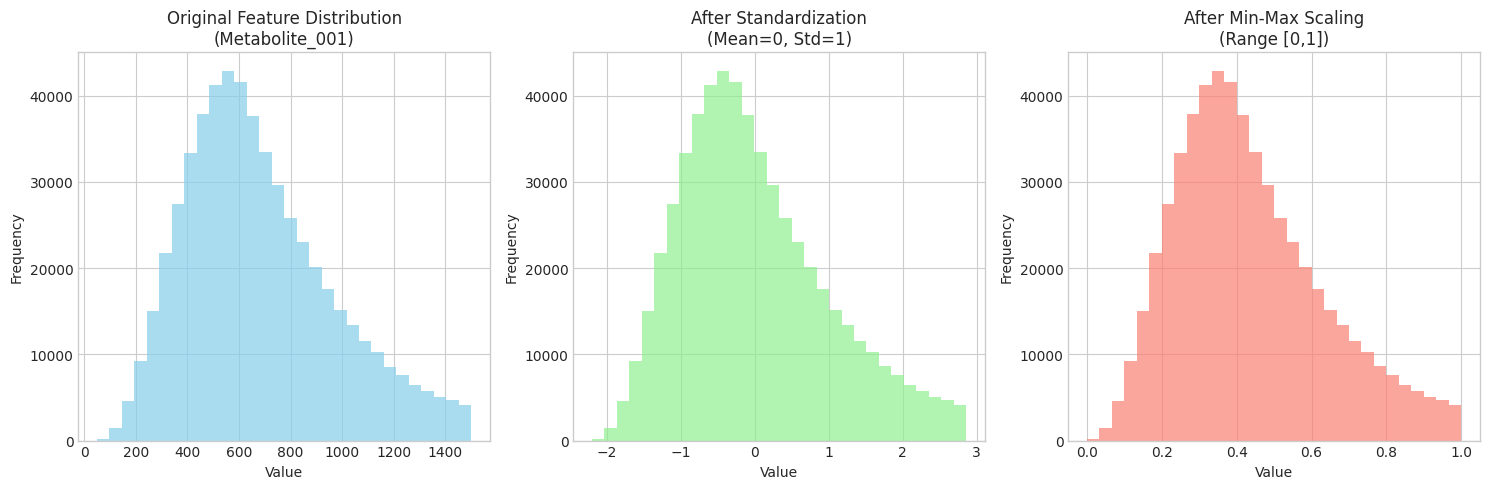

Scaling comparison for first feature:
Original - Mean: 680.722, Std: 286.554
Standardized - Mean: -0.000, Std: 1.000
Min-Max - Min: 0.000, Max: 1.000


In [9]:
# Before scaling - examine feature distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(X_train_imputed.iloc[:, 0], bins=30, alpha=0.7, color='skyblue')
plt.title('Original Feature Distribution\n(Metabolite_001)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Apply Standardization
scaler_standard = StandardScaler()
X_train_standard = pd.DataFrame(
    scaler_standard.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

plt.subplot(1, 3, 2)
plt.hist(X_train_standard.iloc[:, 0], bins=30, alpha=0.7, color='lightgreen')
plt.title('After Standardization\n(Mean=0, Std=1)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Apply Min-Max Scaling
scaler_minmax = MinMaxScaler()
X_train_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

plt.subplot(1, 3, 3)
plt.hist(X_train_minmax.iloc[:, 0], bins=30, alpha=0.7, color='salmon')
plt.title('After Min-Max Scaling\n(Range [0,1])')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print statistics
print("Scaling comparison for first feature:")
print(f"Original - Mean: {X_train_imputed.iloc[:, 0].mean():.3f}, Std: {X_train_imputed.iloc[:, 0].std():.3f}")
print(f"Standardized - Mean: {X_train_standard.iloc[:, 0].mean():.3f}, Std: {X_train_standard.iloc[:, 0].std():.3f}")
print(f"Min-Max - Min: {X_train_minmax.iloc[:, 0].min():.3f}, Max: {X_train_minmax.iloc[:, 0].max():.3f}")

## 5. Handling Imbalanced Datasets

Imbalanced datasets are common in metabolomics where one class (e.g., disease) may be less frequent than another (healthy controls). This can lead to biased models that perform poorly on the minority class. We'll explore two main approaches:

1. **Undersampling**: Reduce the majority class
2. **Oversampling (SMOTE)**: Generate synthetic examples for the minority class

Original class distribution:
has_cl
1    278592
0    277852
Name: count, dtype: int64
Imbalance ratio: 1.00:1


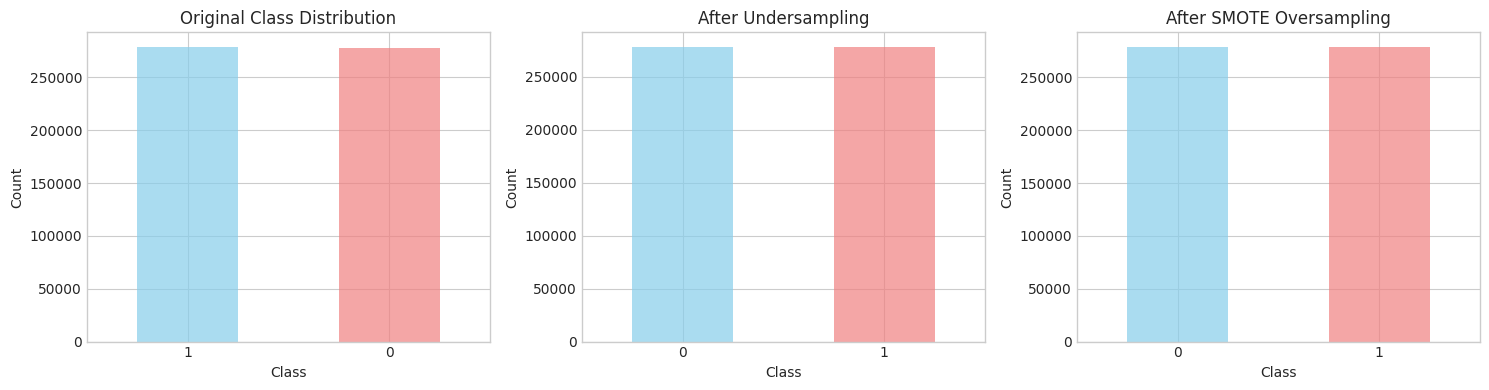


Dataset sizes after balancing:
Original: 556444 samples
Undersampled: 555704 samples
SMOTE: 557184 samples


In [10]:
# Analyze class imbalance on HF train split
class_counts = y_train.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Original class distribution:")
print(class_counts)
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Visualize class distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
class_counts.plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_standard, y_train)

plt.subplot(1, 3, 2)
pd.Series(y_train_under).value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('After Undersampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_standard, y_train)

plt.subplot(1, 3, 3)
pd.Series(y_train_smote).value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('After SMOTE Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print(f"\nDataset sizes after balancing:")
print(f"Original: {len(y_train)} samples")
print(f"Undersampled: {len(y_train_under)} samples")
print(f"SMOTE: {len(y_train_smote)} samples")

**Interpreting the Class Balancing Results Above**
The bar plots show how class distributions change after undersampling and SMOTE. Undersampling reduces the majority class, while SMOTE generates synthetic samples for the minority class. Balanced datasets help models learn equally from both classes, improving performance on the minority class.

## 6. Final Data Preparation Pipeline

Let's create a complete data preparation pipeline that we can use in subsequent notebooks.

In [11]:
def prepare_data_pipeline(X_train, X_val, X_test, y_train, 
                         missing_threshold=0.5, 
                         scaling_method='standard',
                         balance_method=None):
    """
    Prepare data using HF-provided train/val/test splits.
    missing_threshold: drop features with missingness above this proportion.
    scaling_method: 'standard' or 'minmax'
    balance_method: None | 'undersample' | 'smote'
    """
    # 1) Drop high-missing features
    miss_pct = (X_train.isnull().sum() / len(X_train))
    keep_cols = miss_pct[miss_pct <= missing_threshold].index
    X_train_c = X_train[keep_cols]
    X_val_c = X_val[keep_cols]
    X_test_c = X_test[keep_cols]

    # 2) Impute
    imp = SimpleImputer(strategy='median')
    X_train_i = pd.DataFrame(imp.fit_transform(X_train_c), columns=X_train_c.columns, index=X_train_c.index)
    X_val_i = pd.DataFrame(imp.transform(X_val_c), columns=X_val_c.columns, index=X_val_c.index)
    X_test_i = pd.DataFrame(imp.transform(X_test_c), columns=X_test_c.columns, index=X_test_c.index)

    # 3) Scale
    if scaling_method == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    X_train_s = pd.DataFrame(scaler.fit_transform(X_train_i), columns=X_train_i.columns, index=X_train_i.index)
    X_val_s = pd.DataFrame(scaler.transform(X_val_i), columns=X_val_i.columns, index=X_val_i.index)
    X_test_s = pd.DataFrame(scaler.transform(X_test_i), columns=X_test_i.columns, index=X_test_i.index)

    # 4) Optional balance on training only
    if balance_method == 'undersample':
        rus = RandomUnderSampler(random_state=42)
        X_train_b, y_train_b = rus.fit_resample(X_train_s, y_train)
    elif balance_method == 'smote':
        sm = SMOTE(random_state=42)
        X_train_b, y_train_b = sm.fit_resample(X_train_s, y_train)
    else:
        X_train_b, y_train_b = X_train_s, y_train

    return {
        'X_train': X_train_b,
        'y_train': y_train_b,
        'X_val': X_val_s,
        'y_val': y_val,
        'X_test': X_test_s,
        'y_test': y_test
    }

## Summary

In this notebook, we covered the essential steps of data preparation for machine learning in metabolomics:

1. **Data Loading and Exploration**: Understanding your dataset structure and characteristics
2. **Data Splitting**: Properly dividing data into training (80%), validation (10%), and test (10%) sets
3. **Missing Value Handling**: Removing high-missing features and imputing remaining values
4. **Feature Scaling**: Standardization and Min-Max scaling for algorithm compatibility
5. **Imbalanced Data**: Techniques to handle class imbalance using undersampling and SMOTE
6. **Pipeline Creation**: Building a reusable data preparation pipeline

### Key Takeaways:
- Always fit preprocessors on training data only to avoid data leakage
- Choose imputation and scaling strategies based on your data characteristics
- Consider class imbalance and its impact on model performance
- Create reproducible pipelines for consistent preprocessing

### Next Steps:
In the next notebook, we'll use this prepared data to train and tune machine learning models, building on the foundation we've established here.